In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-03-13 18:06:03.341964: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 18:06:03.780489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
TIME_INTERVAL = 1

In [3]:
trajectory_list = read_trajectory(f'data/trajs_fov_0.csv')
label_list = read_andi2_trajectory_label(f'data/traj_labs_fov_0.txt')

trajectory_object = trajectory_list[0]
trajectory_label = label_list[0]
print(trajectory_object.get_diffusion_coefs(time_interval=TIME_INTERVAL)[:10])

[0.11307297 0.29040009 0.32801238 0.60620293 0.40873293 0.37981081
 0.29876261 0.72632612 1.16533114 0.72088607]


In [4]:
msd = trajectory_object.get_msd(time_interval=TIME_INTERVAL)
diff_coefs = trajectory_object.get_diffusion_coefs(time_interval=TIME_INTERVAL)
angles = trajectory_object.get_trajectory_angles(time_interval=TIME_INTERVAL)

xs = trajectory_object.get_positions()[:,0]
ys = trajectory_object.get_positions()[:,1]
xs -= xs[0]
ys -= ys[0]

labeled_diff_coefs = trajectory_label[0]
labeled_alphas = trajectory_label[1]
labeled_states = trajectory_label[2]
labeled_cps = trajectory_label[3]

In [5]:
print(msd.shape, diff_coefs.shape, angles.shape, xs.shape, ys.shape)

(167,) (167,) (167,) (167,) (167,)


In [6]:
df = np.array([xs, ys, msd, diff_coefs, angles, labeled_diff_coefs, labeled_alphas, labeled_states, labeled_cps]).T
df = pd.DataFrame(df, columns=['xs', 'ys', 'msd', 'diff_coefs', 'angles', 'label_diff_coefs', 'label_alphas', 'label_states', 'label_cps'])
NUM_FEATURES = df.shape[1]
print(df.shape)

(167, 9)


In [7]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()

for normallization_col in ['xs', 'ys', 'msd', 'diff_coefs', 'angles']:
    train_df[normallization_col] = (train_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]
    val_df[normallization_col] = (val_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]
    test_df[normallization_col] = (test_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]

/tmp/ipykernel_90371/1902673954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[normallization_col] = (train_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]
/tmp/ipykernel_90371/1902673954.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[normallization_col] = (val_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]
/tmp/ipykernel_90371/1902673954.py:7: SettingWithCopyWarning: 
A value is trying to be set on 

         xs        ys       msd  diff_coefs    angles  label_diff_coefs  \
0  0.385907  0.571054 -1.774765   -1.492926 -1.244179          0.090578   
1  0.487645  0.391212 -1.508861   -0.899957  0.558284          0.090578   
2  0.995811  0.300880 -0.896537   -0.774184 -0.061335          0.090578   
3  0.513388 -0.038060 -0.980246    0.156065  0.847677          0.090578   
4  1.344940 -0.748044  0.332509   -0.504260 -2.030788          0.090578   

   label_alphas  label_states  label_cps  
0      0.315004           2.0        0.0  
1      0.315004           2.0        0.0  
2      0.315004           2.0        0.0  
3      0.315004           2.0        0.0  
4      0.315004           2.0        0.0  


/tmp/ipykernel_90371/3937979437.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(df.keys(), rotation=90)


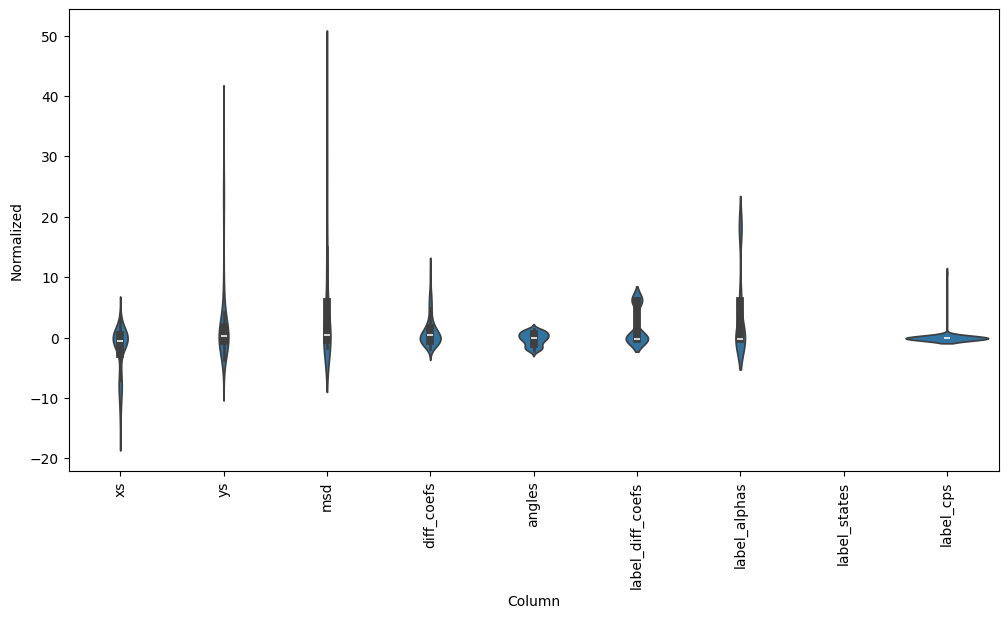

In [9]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

print(train_df.head())

In [10]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [11]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [12]:
def plot(self, model=None, plot_col='xs', max_subplots=3):
  inputs, labels = self.example
  print(inputs.shape)
  print(labels.shape)
  print(inputs[0, :, :])
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      print('pr', predictions.shape, n, label_col_index)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Frame')

WindowGenerator.plot = plot

In [13]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [14]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [15]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [16]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [17]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

2024-03-13 18:06:23.225930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 18:06:23.231245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 18:06:23.231291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 18:06:23.234184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 18:06:23.234230: I tensorflow/compile

Inputs shape (batch, time, features): (32, 24, 9)
Labels shape (batch, time, features): (32, 24, 9)


In [18]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        NUM_FEATURES,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

Epoch 1/20


2024-03-13 18:06:25.924611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda-11.2/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
2024-03-13 18:06:25.929660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-13 18:06:25.932283: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbd440635d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-13 18:06:25.932304: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-13 18:06:25.935683: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03

3/3 [==============================] - 2s 117ms/step - loss: 0.6525 - mean_absolute_error: 0.4710 - val_loss: 4.8989 - val_mean_absolute_error: 1.3442
Epoch 2/20
3/3 [==============================] - 0s 19ms/step - loss: 0.6506 - mean_absolute_error: 0.4703 - val_loss: 4.9000 - val_mean_absolute_error: 1.3452
Epoch 3/20
3/3 [==============================] - 0s 18ms/step - loss: 0.6485 - mean_absolute_error: 0.4694 - val_loss: 4.9014 - val_mean_absolute_error: 1.3458
CPU times: user 1.93 s, sys: 249 ms, total: 2.18 s
Wall time: 2.13 s


In [19]:
IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
#performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()

1/1 [==============================] - 0s 29ms/step - loss: 4.9014 - mean_absolute_error: 1.3458



In [20]:
train_set = np.array(train_df).reshape(1, train_df.shape[0], NUM_FEATURES)
pred_set = np.array(test_df).reshape(1, test_df.shape[0], NUM_FEATURES)
train_result = residual_lstm.predict(train_set)
pred_result = residual_lstm.predict(pred_set)

1/1 [==============================] - 0s 159ms/step


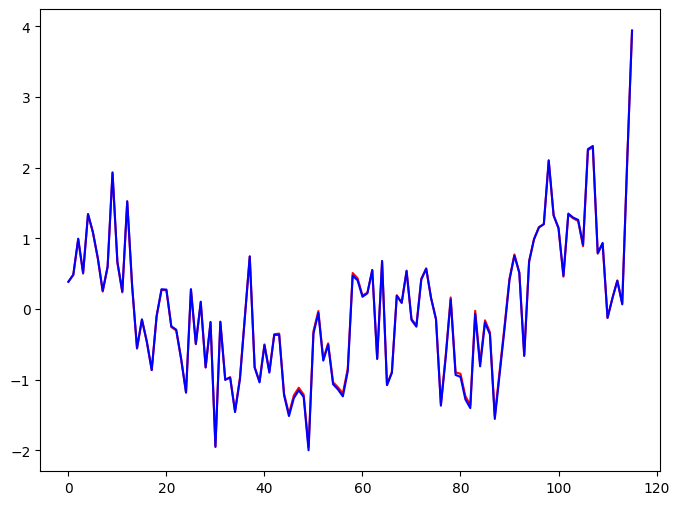

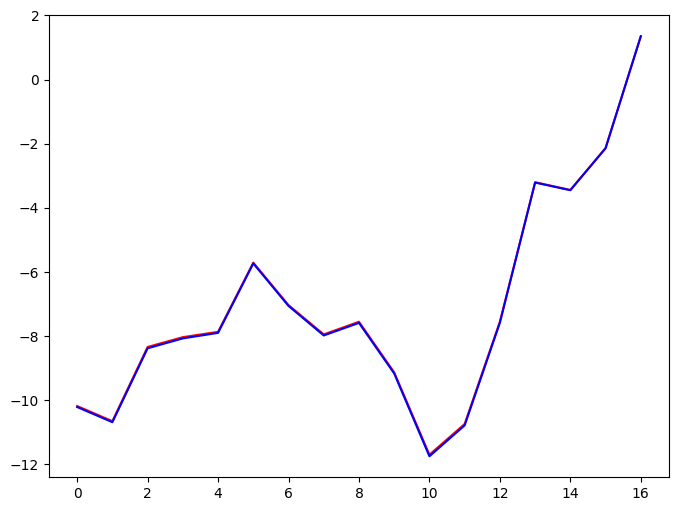

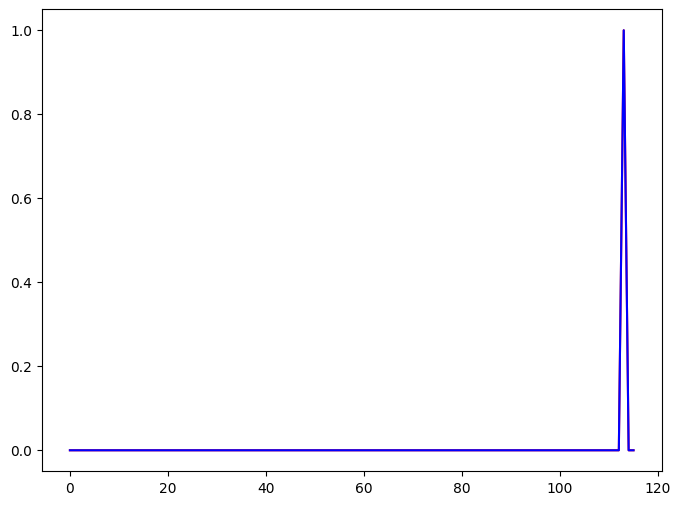

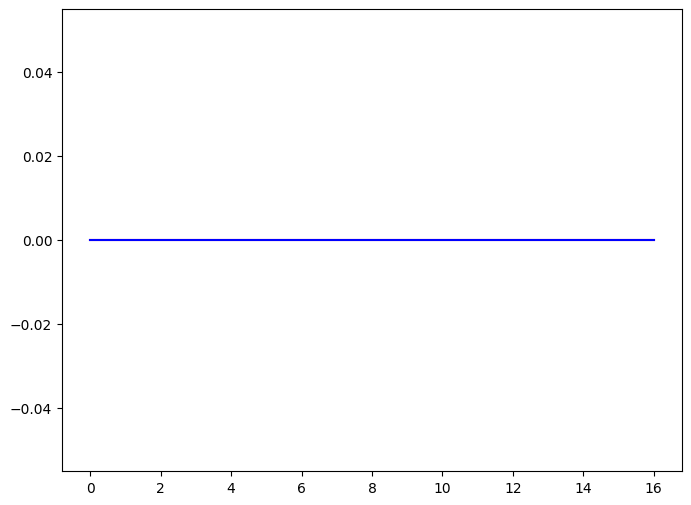

In [27]:
plt.figure()
plt.plot(np.arange(train_result.shape[1]), train_result[0,:,0], c='red')
plt.plot(np.arange(train_df.shape[0]), train_df['xs'], c='blue')

plt.figure()
plt.plot(np.arange(pred_result.shape[1]), pred_result[0,:,0], c='red')
plt.plot(np.arange(test_df.shape[0]), test_df['xs'], c='blue')

plt.figure()
plt.plot(np.arange(train_result.shape[1]), np.round(train_result[0,:,8]), c='red')
plt.plot(np.arange(train_df.shape[0]), train_df['label_cps'], c='blue')

plt.figure()
plt.plot(np.arange(pred_result.shape[1]), np.round(pred_result[0,:,8]), c='red')
plt.plot(np.arange(test_df.shape[0]), test_df['label_cps'], c='blue')

In [49]:
trajectory_object = trajectory_list[36]
trajectory_label = label_list[36]
msd = trajectory_object.get_msd(time_interval=TIME_INTERVAL)
diff_coefs = trajectory_object.get_diffusion_coefs(time_interval=TIME_INTERVAL)
angles = trajectory_object.get_trajectory_angles(time_interval=TIME_INTERVAL)

xs = trajectory_object.get_positions()[:,0]
ys = trajectory_object.get_positions()[:,1]
xs -= xs[0]
ys -= ys[0]

labeled_diff_coefs = trajectory_label[0]
labeled_alphas = trajectory_label[1]
labeled_states = trajectory_label[2]
labeled_cps = trajectory_label[3]

df = np.array([xs, ys, msd, diff_coefs, angles, labeled_diff_coefs, labeled_alphas, labeled_states, labeled_cps]).T
df = pd.DataFrame(df, columns=['xs', 'ys', 'msd', 'diff_coefs', 'angles', 'label_diff_coefs', 'label_alphas', 'label_states', 'label_cps'])

n = len(df)
test_df = df
test_mean = df.mean()
test_std = df.std()
for normallization_col in ['xs', 'ys', 'msd', 'diff_coefs', 'angles']:
    test_df[normallization_col] = (test_df[normallization_col] - test_mean[normallization_col]) / test_std[normallization_col]
    
test_set = np.array(test_df).reshape(1, test_df.shape[0], NUM_FEATURES)
test_result = residual_lstm.predict(test_set)

1/1 [==============================] - 0s 18ms/step


(array([ 9, 76]),)


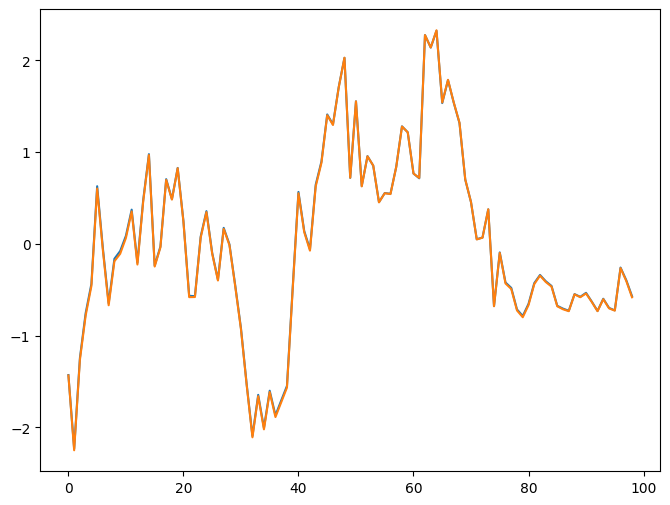

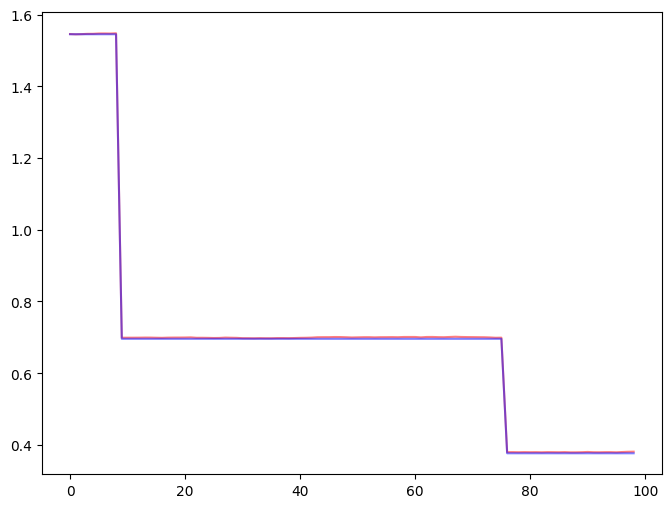

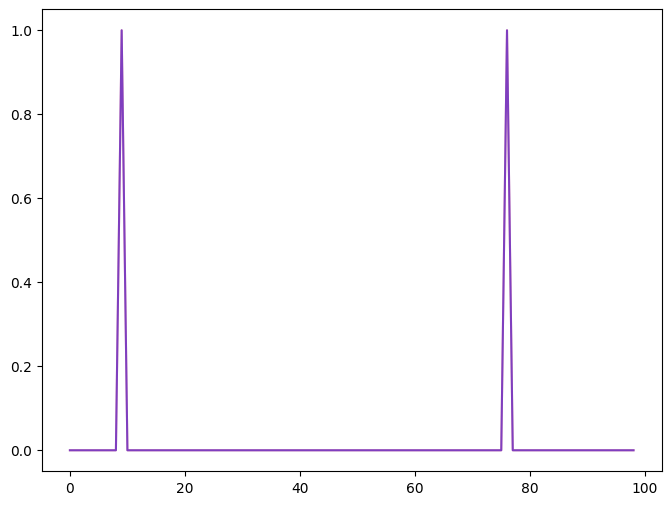

In [50]:
plt.figure()
plt.plot(np.arange(test_result.shape[1]), test_result[0,:,0])
plt.plot(np.arange(test_df.shape[0]), test_df['xs'])

plt.figure()
plt.plot(np.arange(test_result.shape[1]), (test_result[0,:,6]), c='red', alpha=0.5)
plt.plot(np.arange(test_df.shape[0]), test_df['label_alphas'], c='blue', alpha=0.5)

plt.figure()
plt.plot(np.arange(test_result.shape[1]), (np.round(test_result[0,:,8])).astype(np.uint8), c='red', alpha=0.5)
plt.plot(np.arange(test_df.shape[0]), test_df['label_cps'], c='blue', alpha=0.5)
print(np.where((np.round(test_result[0,:,8])).astype(np.uint8) == 1))